In [9]:
import pandas as pd
import numpy as np
import boto3
import matplotlib.pyplot as plt
import seaborn as sns
import io

# Connect to S3
s3 = boto3.client('s3')
bucket_name = 'chevron-datathon-2025-2yltdsus'  

# Function to read Excel data from S3
def read_excel_from_s3(bucket, key):
    obj = s3.get_object(Bucket=bucket, Key=key)
    data = obj['Body'].read()
    return pd.read_excel(io.BytesIO(data))

# Load training data
try:
    # Note: using the exact paths from your S3 bucket
    training_data = read_excel_from_s3(bucket_name, 'raw/training.xlsx')
    scoring_data = read_excel_from_s3(bucket_name, 'raw/scoring.xlsx')
    data_dictionary = read_excel_from_s3(bucket_name, 'raw/data_dictionary.xlsx')
    
    # Look at your data
    print("Training Data Shape:", training_data.shape)
    print("\nColumns in the data:", training_data.columns.tolist())
    print("\nFirst few rows of training data:")
    display(training_data.head())
    
    print("\nData Dictionary:")
    display(data_dictionary)
    
except Exception as e:
    print("Error occurred:", str(e))
    print("\nPlease verify the following:")
    print("1. Bucket name:", bucket_name)
    print("2. Files exist in:", 'raw/')

Training Data Shape: (41053, 10)

Columns in the data: ['Date', 'Vehicle Category', 'GVWR Class', 'Fuel Type', 'Model Year', 'Fuel Technology', 'Electric Mile Range', 'Number of Vehicles Registered at the Same Address', 'Region', 'Vehicle Population']

First few rows of training data:


,Date,Vehicle Category,GVWR Class,Fuel Type,Model Year,Fuel Technology,Electric Mile Range,Number of Vehicles Registered at the Same Address,Region,Vehicle Population
0,2019,P,Not Applicable,Gasoline,2020.0,ICE,Not Applicable,≥4,Statewide,395883
1,2020,P,Not Applicable,Gasoline,2020.0,ICE,Not Applicable,1,Statewide,370954
2,2021,P,Not Applicable,Gasoline,2020.0,ICE,Not Applicable,1,Statewide,349406
3,2019,P,Not Applicable,Gasoline,2019.0,ICE,Not Applicable,≥4,Statewide,348475
4,2019,P,Not Applicable,Gasoline,2018.0,ICE,Not Applicable,≥4,Statewide,333296



Data Dictionary:


,Column,Description
0,Date,The year of the inventory
1,Vehicle Category,"The category of the vehicle, i.e. passenger ca..."
2,GVWR Class,Gross Vehicle Weight Rating or the amount of w...
3,Fuel Type,"The type of fuel, i.e. gasoline, electric, hyd..."
4,Model Year,Model year of vehicles
5,Fuel Technology,"The type of engine, i.e. internal combustion e..."
6,Electric Mile Range,How far the vehicle travels on a single charge
7,Number of Vehicles Registered at the Same Address,How many vehicles are registered to the same a...
8,Region,"How the count is aggregated, i.e. for the enti..."
9,Vehicle Population,"Target, Count of Vehicles per feature combination"


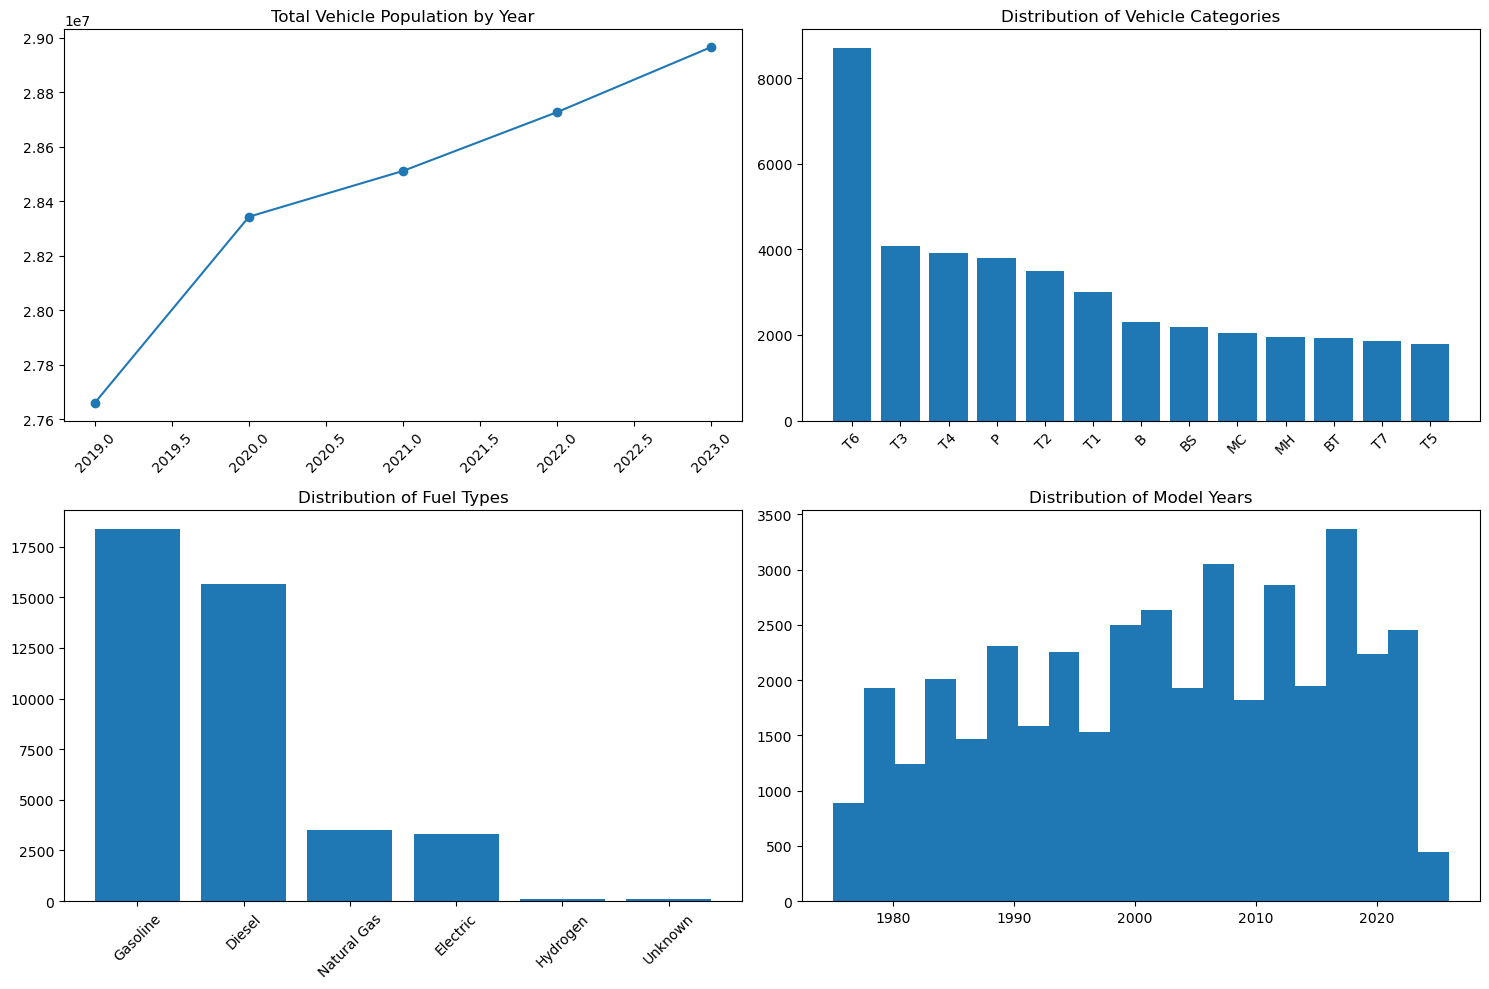


Summary Statistics:

Mean Vehicle Population by Year:
Date
2019    3357.626973
2020    3508.187028
2021    3378.041706
2022    3324.805324
2023    3783.298589
Name: Vehicle Population, dtype: float64

Vehicle Count by Fuel Type:
Fuel Type
Gasoline       135283493
Diesel           5859674
Electric          894158
Natural Gas       151048
Hydrogen           15159
Unknown             1166
Name: Vehicle Population, dtype: int64


In [11]:
# Basic data visualization and analysis
import matplotlib.pyplot as plt
import seaborn as sns

# Create subplots
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))

# 1. Vehicle Population by Year
yearly_pop = training_data.groupby('Date')['Vehicle Population'].sum()
ax1.plot(yearly_pop.index, yearly_pop.values, marker='o')
ax1.set_title('Total Vehicle Population by Year')
ax1.tick_params(axis='x', rotation=45)

# 2. Vehicle Types Distribution
vehicle_counts = training_data['Vehicle Category'].value_counts()
ax2.bar(vehicle_counts.index, vehicle_counts.values)
ax2.set_title('Distribution of Vehicle Categories')
ax2.tick_params(axis='x', rotation=45)

# 3. Fuel Type Distribution
fuel_counts = training_data['Fuel Type'].value_counts()
ax3.bar(fuel_counts.index, fuel_counts.values)
ax3.set_title('Distribution of Fuel Types')
ax3.tick_params(axis='x', rotation=45)

# 4. Model Year Distribution
ax4.hist(training_data['Model Year'].dropna(), bins=20)
ax4.set_title('Distribution of Model Years')

plt.tight_layout()
plt.show()

# Print some summary statistics
print("\nSummary Statistics:")
print("\nMean Vehicle Population by Year:")
print(training_data.groupby('Date')['Vehicle Population'].mean())

print("\nVehicle Count by Fuel Type:")
print(training_data.groupby('Fuel Type')['Vehicle Population'].sum().sort_values(ascending=False))

In [12]:
# Data preparation for modeling
def prepare_data(df):
    # Create a copy to avoid modifying original data
    df_prep = df.copy()
    
    # Convert Date to numeric (years since 2019)
    df_prep['Years_Since_2019'] = df_prep['Date'] - 2019
    
    # Convert categorical variables to numeric
    df_prep = pd.get_dummies(df_prep, columns=['Vehicle Category', 'Fuel Type', 'Fuel Technology', 'GVWR Class'])
    
    # Clean up the 'Number of Vehicles Registered at the Same Address'
    df_prep['Number_Vehicles'] = df_prep['Number of Vehicles Registered at the Same Address'].map({'1': 1, '2': 2, '3': 3, '≥4': 4})
    
    return df_prep

# Prepare the data
training_processed = prepare_data(training_data)
scoring_processed = prepare_data(scoring_data)

print("\nProcessed Features:")
print(training_processed.columns.tolist())


Processed Features:
['Date', 'Model Year', 'Electric Mile Range', 'Number of Vehicles Registered at the Same Address', 'Region', 'Vehicle Population', 'Years_Since_2019', 'Vehicle Category_B', 'Vehicle Category_BS', 'Vehicle Category_BT', 'Vehicle Category_MC', 'Vehicle Category_MH', 'Vehicle Category_P', 'Vehicle Category_T1', 'Vehicle Category_T2', 'Vehicle Category_T3', 'Vehicle Category_T4', 'Vehicle Category_T5', 'Vehicle Category_T6', 'Vehicle Category_T7', 'Fuel Type_Diesel', 'Fuel Type_Electric', 'Fuel Type_Gasoline', 'Fuel Type_Hydrogen', 'Fuel Type_Natural Gas', 'Fuel Type_Unknown', 'Fuel Technology_BEV', 'Fuel Technology_FCEV', 'Fuel Technology_ICE', 'Fuel Technology_PHEV', 'GVWR Class_1', 'GVWR Class_2', 'GVWR Class_3', 'GVWR Class_4', 'GVWR Class_5', 'GVWR Class_6', 'GVWR Class_7', 'GVWR Class_8', 'GVWR Class_Not Applicable', 'GVWR Class_Unknown', 'Number_Vehicles']


In [16]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.impute import SimpleImputer
import numpy as np

def prepare_final_features(df, training=True, feature_names=None):
    features = df.copy()
    
    # Drop non-numeric or unnecessary columns
    columns_to_drop = ['Date', 'Electric Mile Range', 'Region', 
                      'Number of Vehicles Registered at the Same Address',
                      'Vehicle Population']
    
    features = features.drop(columns_to_drop, axis=1)
    
    # Create imputer for numerical columns
    imputer = SimpleImputer(strategy='mean')
    
    # Get numeric columns
    numeric_cols = features.select_dtypes(include=['float64', 'int64']).columns
    
    # Impute missing values in numeric columns
    features[numeric_cols] = imputer.fit_transform(features[numeric_cols])
    
    if training:
        return features, features.columns
    else:
        # Ensure all training features exist in scoring data
        for col in feature_names:
            if col not in features.columns:
                features[col] = 0
        # Keep only the columns that were in training
        features = features[feature_names]
        return features

# Prepare training data
X, feature_names = prepare_final_features(training_processed, training=True)
y = training_processed['Vehicle Population']

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and train model
model = GradientBoostingRegressor(
    n_estimators=200,
    learning_rate=0.1,
    max_depth=5,
    random_state=42
)

# Train model
model.fit(X_train, y_train)

# Make predictions and evaluate
train_pred = model.predict(X_train)
test_pred = model.predict(X_test)

# Calculate RMSE
train_rmse = np.sqrt(mean_squared_error(y_train, train_pred))
test_rmse = np.sqrt(mean_squared_error(y_test, test_pred))

print("Model Performance:")
print("Training RMSE:", train_rmse)
print("Testing RMSE:", test_rmse)

# Prepare scoring data using the same features as training
X_scoring = prepare_final_features(scoring_processed, training=False, feature_names=feature_names)
final_predictions = model.predict(X_scoring)

# Create submission dataframe
submissions = pd.DataFrame({
    'prediction': final_predictions
})

print("\nPrediction Summary:")
print(submissions.describe())

# Feature importance
feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': model.feature_importances_
}).sort_values('importance', ascending=False)

print("\nTop 10 Most Important Features:")
print(feature_importance.head(10))

Model Performance:
Training RMSE: 6027.681779734933
Testing RMSE: 6726.289074753533

Prediction Summary:
          prediction
count    7546.000000
mean     3618.733309
std     19194.333307
min    -84251.747871
25%      -193.488865
50%        49.417479
75%       975.533015
max    245830.889992

Top 10 Most Important Features:
                feature  importance
23  Fuel Technology_ICE    0.285835
0            Model Year    0.271852
17   Fuel Type_Gasoline    0.268541
7    Vehicle Category_P    0.094115
25         GVWR Class_1    0.017608
9   Vehicle Category_T2    0.016347
1      Years_Since_2019    0.011443
26         GVWR Class_2    0.009225
10  Vehicle Category_T3    0.006666
8   Vehicle Category_T1    0.004767


In [17]:
# Add constraints to predictions
def constrain_predictions(predictions):
    return np.clip(predictions, 0, 100000)  # Adjust upper limit based on your domain knowledge

# Update predictions with constraints
final_predictions = constrain_predictions(final_predictions)

# Check updated prediction statistics
print("Updated Prediction Summary:")
print(pd.DataFrame({'prediction': final_predictions}).describe())

Updated Prediction Summary:
          prediction
count    7546.000000
mean     3363.560977
std     12817.345772
min         0.000000
25%         0.000000
50%        49.417479
75%       975.533015
max    100000.000000


In [18]:
# Create submission file
submission_df = pd.DataFrame({
    'prediction': final_predictions
})

# Save predictions to Excel
submission_df.to_excel('submission_file.xlsx', sheet_name='Predictions', index=False)

print("\nSubmission file has been created!")


Submission file has been created!


In [19]:
# Print model insights
print("\nKey Model Insights:")
print(f"1. Our model's test RMSE is {test_rmse:.2f}")
print("\n2. Most important features for prediction:")
for idx, row in feature_importance.head(5).iterrows():
    print(f"   - {row['feature']}: {row['importance']:.3f}")

print("\n3. Prediction Distribution:")
print(f"   - Mean prediction: {final_predictions.mean():.2f}")
print(f"   - Median prediction: {np.median(final_predictions):.2f}")
print(f"   - Standard deviation: {final_predictions.std():.2f}")


Key Model Insights:
1. Our model's test RMSE is 6726.29

2. Most important features for prediction:
   - Fuel Technology_ICE: 0.286
   - Model Year: 0.272
   - Fuel Type_Gasoline: 0.269
   - Vehicle Category_P: 0.094
   - GVWR Class_1: 0.018

3. Prediction Distribution:
   - Mean prediction: 3363.56
   - Median prediction: 49.42
   - Standard deviation: 12816.50


In [21]:
!pip install xgboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 24.9 MB/s eta 0:00:0000:01


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/xgboost/core.py:265: FutureWarning: Your system has an old version of glibc (< 2.28). We will stop supporting Linux distros with glibc older than 2.28 after **May 31, 2025**. Please upgrade to a recent Linux distro (with glibc 2.28+) to use future versions of XGBoost.
Note: You have installed the 'manylinux2014' variant of XGBoost. Certain features such as GPU algorithms or federated learning are not available. To use these features, please upgrade to a recent Linux distro with glibc 2.28+, and install the 'manylinux_2_28' variant.
  warnings.warn(


KeyError: 'GVWR Class'